In [1]:
from montecarlo import *
from heston import *

from matplotlib import pyplot as plt

In [2]:
def getPhiAB(u, tau, k, sig, theta, rho, v):
    
    xi = k - sig * rho * u * 1j
    d = np.sqrt( xi ** 2 + sig**2 * (1j * u + u ** 2) + 0j)
    
    s = np.sinh(d*tau/2)
    c = np.cosh(d*tau/2)
    A1 = (1j*u + u**2)*s
    A2 = d*c + xi*s
    A = A1 / A2
    
    D = np.log(d) + (k-d)*tau/2 - np.log((d+xi)/2 + (d-xi)/2*np.exp(-d * tau))
    
    pred_phi = np.exp(-k * theta * rho * tau * u * 1j / sig - A * v + 2 * k * theta / sig ** 2 * D)
    return pred_phi

In [3]:
def getOptionPriceAB(S, K, Nu, tau, r, v, theta, rho, k, sig, isCall=True):
    
    if not isinstance(S, np.ndarray):
        S = np.asarray([S])
    if not isinstance(K, np.ndarray):
        K = np.asarray([K])
    if not isinstance(v, np.ndarray):
        v = np.asarray([v])
    #dims go as follow:
    #K S v u
    S = S.reshape(1, -1, 1, 1)
    K = K.reshape(-1, 1, 1, 1)
    v = v.reshape(1, 1, -1, 1)

    Ns = S.size
    Nk = K.size
    Nv = v.size

    un, hn = getMesh(Nu)

    un = un.reshape(1, 1, 1, -1)
    hn = hn.reshape(1, 1, 1, -1)
    
    xn = np.log(S * np.exp(r * tau) / K)
    

    batchSize = 100

    I1 = np.zeros((Nk, Ns, Nv, 1))
    I2 = np.zeros((Nk, Ns, Nv, 1))
    for i in range(Nu // batchSize):
        start = i * batchSize
        end = start + batchSize
        unbatch = un[:, :, :, start:end]
        hnbatch = hn[:, :, :, start:end]
        
        pred_phi = getPhiAB(unbatch, tau, k, sig, theta, rho, v)
        pred_phi_tilda = getPhiAB(unbatch - 1j, tau, k, sig, theta, rho, v)

        F1 = np.exp(1j * unbatch * xn) * pred_phi / (1j * unbatch)
        F2 = np.exp(1j * unbatch * xn) * pred_phi_tilda / (1j * unbatch)
        
        F1 = F1.real * hnbatch
        F2 = F2.real * hnbatch
        
        #F1 = F1.real * np.sin(hnbatch * xn / 2) * 2 / xn
        #F2 = F2.real * np.sin(hnbatch * xn / 2) * 2 / xn

        
        I1 += np.sum(F1, axis=-1, keepdims=True) / np.pi
        I2 += np.sum(F2, axis=-1, keepdims=True) / np.pi
    assert I1.shape == (Nk, Ns, Nv, 1)
    if isCall:
        P1 = 0.5 + I1
        P2 = 0.5 + I2
        res = S * P2 - np.exp(-r * tau) * K * P1
    else:
        P1 = 0.5 - I1
        P2 = 0.5 - I2
        res = np.exp(-r * tau) * K * P1 - S * P2
    return res.squeeze()

In [4]:
def getPhiABder(u, tau, k, sig, theta, rho, v):
    xi = k - sig * rho * u * 1j
    d = np.sqrt( xi ** 2 + sig**2 * (1j * u + u ** 2) + 0j)
    
    
    c = np.cosh(d * tau / 2)
    s = np.sinh(d * tau / 2)
    
    A1 = (1j * u + u ** 2) * s
    A2 = (d * c + xi * s)
    A = A1 / A2
    
    B = d * np.exp(k * tau / 2) / A2
    
    D = np.log(d) + (k - d) * tau / 2 - np.log( (d + xi)/2 + (d-xi)/2 * np.exp(-d*tau) )
    
    pred_phi = np.exp(-k * theta * rho * tau * u * 1j / sig - A * v + 2 * k * theta / sig ** 2 * D)
    
    der1 = -A
    der2 = 2 * k / sig ** 2 * D - k * rho * tau * 1j * u / sig
    
    d_rho = -1j * u * sig * xi / d

    A1_rho = -1j * u * sig * tau * xi / (2 * d) * (u ** 2 + 1j * u) * c
    A2_rho = -(2 + xi * tau) * sig * 1j * u / (2 * d) * (xi * c + d * s)
    
    B_rho = np.exp(k * tau / 2) * (d_rho - d * A2_rho / A2) / A2
    A_rho = (A1_rho - A * A2_rho) / A2
    
    D_rho = B_rho / B
       
    der3 = -k * theta * tau * 1j * u / sig - v * A_rho + 2 * k * theta / sig **2 * D_rho
    
    A_k = A_rho * 1j / (u * sig)
    B_k = tau / 2 * B + B_rho * 1j / (u * sig)
    D_k = B_k / B
    
    der4 = -theta * rho * tau * 1j * u / sig - v * A_k + 2 * theta / sig**2 * D + 2 * k * theta / sig ** 2 * D_k
    
    d_sig = (sig * (1j * u + u ** 2) + rho * 1j * u * (sig * rho * 1j * u - k)) / d
    A1_sig = (1j * u + u ** 2) * tau / 2 * c * d_sig
    A2_sig = d_sig * ( c * (1 + xi * tau / 2) + d * tau / 2 * s) - s * rho * 1j * u
    
    A_sig = (A1_sig - A * A2_sig) / A2
    
    D_sig = d_sig / d - A2_sig / A2
    
    der5 = k * theta * rho * tau * 1j * u / sig ** 2 - v * A_sig - 4 * k * theta / sig**3 * D\
        + 2 * k * theta / sig ** 2 * D_sig
    
    return pred_phi, der1, der2, der3, der4, der5

In [5]:
def getPhiABderFinite(u, tau, k, sig, theta, rho, v):
    pred_phi = getPhiAB(u, tau, k, sig, theta, rho, v)
    
    eps = 1e-10
    denom = 1 / (2 * eps * pred_phi)
    der1 = (getPhiAB(u, tau, k, sig, theta, rho, v + eps) - getPhiAB(u, tau, k, sig, theta, rho, v - eps)) * denom 
    der2 = (getPhiAB(u, tau, k, sig, theta + eps, rho, v) - getPhiAB(u, tau, k, sig, theta - eps, rho, v)) * denom 
    der3 = (getPhiAB(u, tau, k, sig, theta, rho + eps, v) - getPhiAB(u, tau, k, sig, theta, rho - eps, v)) * denom 
    der4 = (getPhiAB(u, tau, k + eps, sig, theta, rho, v) - getPhiAB(u, tau, k - eps, sig, theta, rho, v)) * denom 
    der5 = (getPhiAB(u, tau, k, sig + eps, theta, rho, v) - getPhiAB(u, tau, k, sig - eps, theta, rho, v)) * denom 
    return pred_phi, der1, der2, der3, der4, der5

In [6]:
def calc_int(F, h, dirs):
    I = np.sum( (F * h).real, axis=-1, keepdims=True) / np.pi
    Is = []
    for i in range(5):
        Is.append( np.sum( (F * h * dirs[i]).real, axis=-1, keepdims=True) / np.pi )
    return I, Is

In [7]:
def getOptionPriceABDer(S, K, Nu, tau, r, v, theta, rho, k, sig):
    
    if not isinstance(S, np.ndarray):
        S = np.asarray([S])
    if not isinstance(K, np.ndarray):
        K = np.asarray([K])
    if not isinstance(v, np.ndarray):
        v = np.asarray([v])
    #dims go as follow:
    #K S v u
    S = S.reshape(1, -1, 1, 1)
    K = K.reshape(-1, 1, 1, 1)
    v = v.reshape(1, 1, -1, 1)

    Ns = S.size
    Nk = K.size
    Nv = v.size

    un, hn = getMesh(Nu)

    un = un.reshape(1, 1, 1, -1)
    hn = hn.reshape(1, 1, 1, -1)
    
    xn = np.log(S * np.exp(r * tau) / K)
    

    batchSize = 100

    I1 = np.zeros((Nk, Ns, Nv, 1))
    I2 = np.zeros((Nk, Ns, Nv, 1))
    Der1 = []
    Der2 = []
    for i in range(5):
        Der1.append(np.zeros((Nk, Ns, Nv, 1)))
        Der2.append(np.zeros((Nk, Ns, Nv, 1)))
    params = (tau, k, sig, theta, rho, v)
    for i in range(Nu // batchSize):
        start = i * batchSize
        end = start + batchSize
        unbatch = un[:, :, :, start:end]
        hnbatch = hn[:, :, :, start:end]
        
        phi,  dir1,  dir2,  dir3,  dir4,  dir5  = getPhiABder(unbatch, *params)
        phiT, dir1T, dir2T, dir3T, dir4T, dir5T = getPhiABder(unbatch - 1j, *params)

        F1 = np.exp(1j * unbatch * xn) * phi / (1j * unbatch)
        F2 = np.exp(1j * unbatch * xn) * phiT / (1j * unbatch)

        I1_, Der1_ = calc_int(F1, hnbatch, [dir1,  dir2,  dir3,  dir4,  dir5])
        I2_, Der2_ = calc_int(F2, hnbatch, [dir1T,  dir2T,  dir3T,  dir4T,  dir5T])
        I1 += I1_
        I2 += I2_
        for i in range(5):
            Der1[i] += Der1_[i]
            Der2[i] += Der2_[i]
    
    P1 = 0.5 + I1
    P2 = 0.5 + I2
    res = S * P2 - np.exp(-r * tau) * K * P1
    res_dir = []
    
    for i in range(5):
        tmp = S * Der2[i] - np.exp(-r * tau) * K * Der1[i]
        res_dir.append( tmp.squeeze() )
    return res.squeeze(), res_dir

In [8]:
def getOptionPriceFinite(S, K, Nu, tau, r, k, sig, theta, rho, v):
    C = getOptionPrice(S, K, Nu, tau, r, k, sig, theta, rho, v)
    
    eps = 1e-10
    denom = 1 / (2 * eps)
    der1 = (getOptionPrice(S, K, Nu, tau, r, k, sig, theta, rho, v+eps) - getOptionPrice(S, K, Nu, tau, r, k, sig, theta, rho, v-eps)) * denom 
    der2 = (getOptionPrice(S, K, Nu, tau, r, k, sig, theta+eps, rho, v) - getOptionPrice(S, K, Nu, tau, r, k, sig, theta-eps, rho, v)) * denom 
    der3 = (getOptionPrice(S, K, Nu, tau, r, k, sig, theta, rho+eps, v) - getOptionPrice(S, K, Nu, tau, r, k, sig, theta, rho-eps, v)) * denom 
    der4 = (getOptionPrice(S, K, Nu, tau, r, k+eps, sig, theta, rho, v) - getOptionPrice(S, K, Nu, tau, r, k-eps, sig, theta, rho, v)) * denom 
    der5 = (getOptionPrice(S, K, Nu, tau, r, k, sig+eps, theta, rho, v) - getOptionPrice(S, K, Nu, tau, r, k, sig-eps, theta, rho, v)) * denom 
    return C, [der1, der2, der3, der4, der5]

In [9]:
def getOptionSurface(S, Kn, Nu, Tn, r, k, sig, theta, rho, v):
    Nk = len(Kn)
    Nt = len(Tn)
    res = np.zeros((Nk, Nt))
    
    for t, tau in enumerate(Tn):
        res[:, t] = getOptionPriceAB(S, Kn, Nu, tau, r, k, sig, theta, rho, v0)
    
    return res

In [10]:
from scipy import stats as sps
from scipy.optimize import root_scalar

def BS(K, S, r, tau, vol):
    F = S * np.exp(r * tau)
    d1 = (np.log(F / K) + 0.5 * vol ** 2 * tau) \
                / (vol * np.sqrt(tau))
    d2 = d1 - vol * np.sqrt(tau)
    
    D = np.exp(-r * tau)
    call_price =  D *  ( F * sps.norm.cdf(d1) - K * sps.norm.cdf(d2) )
    return call_price


def getIV(call_prices, Ks, F, r, tau):
    
    res = []
    for call_price, K in zip(call_prices, Ks):
        def foo(vol):
            call_price_ = BS(K, F, r, tau, vol)
            return call_price_ - call_price
 
        v0 = 1e-15
        v1 = 100
        
        br = foo(v0) <= 0 and foo(v1) >= 0
        vol = np.nan
        if br:
            vol = root_scalar(foo, bracket=[v0, v1], method='bisect').root
        res.append( vol )
    return np.asarray(res)

In [11]:
def getVolatilitySurface(S, Kn, Nu, Tn, r, k, sig, theta, rho, v):
    Nk = len(Kn)
    Nt = len(Tn)
    C = np.zeros((Nk, Nt))
    IV = np.zeros((Nk, Nt))
    for t, tau in enumerate(Tn):
        C[:, t] = getOptionPrice(S, Kn, Nu, tau, r, k, sig, theta, rho, v0)
        IV[:, t] = getIV(C[:, t], Kn, S, r, tau)
    return C, IV

In [12]:
r = 0.0
d = 0.55
k = 2.5
sig = 0.9
theta = 0.015
rho = 0.8


S0 = 1.0
K = 1.0
T = 1.5

Kn = K * np.exp( np.linspace(-np.log(15), np.log(5), 100) )
Sn = S0 * np.exp( np.linspace(-np.log(15), np.log(2), 120) )

#Kn = Kn.reshape(-1, 1)
#Sn = Sn.reshape()


Nt = 100
Nu = 1000
tn = np.linspace(0, T, Nt)

v0 = 0.175
x0 = np.log(S0)

In [13]:
C1 = getOptionPrice(S0, Kn, Nu, T, r, k, sig, theta, rho, v0)

C2 = getOptionPriceAB(S0, Kn, Nu, T, r, v0, theta, rho, k, sig)

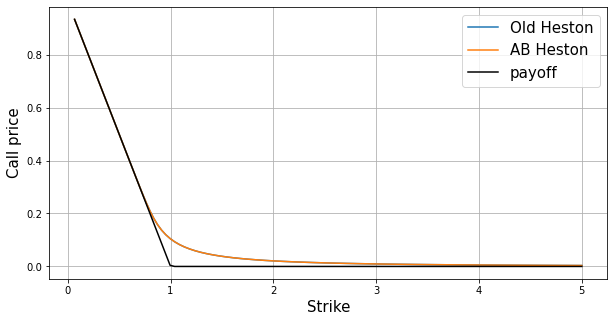

In [14]:
plt.figure(figsize=(10, 5))
plt.plot(Kn, C1, label='Old Heston')
plt.plot(Kn, C2, label='AB Heston')
plt.plot(Kn, np.maximum(S0 - Kn, 0.0), c='k', label='payoff')

plt.legend(fontsize=15)
plt.grid()
plt.xlabel("Strike", fontsize=15)
plt.ylabel("Call price", fontsize=15)
None

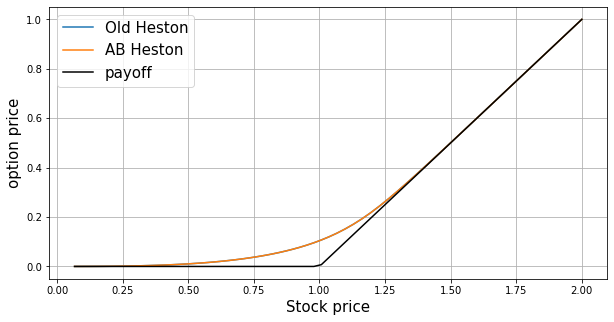

In [15]:
C1 = getOptionPrice(Sn, K, Nu, T, r, k, sig, theta, rho, v0)

C2 = getOptionPriceAB(Sn, K, Nu, T, r, v0, theta, rho, k, sig)

plt.figure(figsize=(10, 5))
plt.plot(Sn, C1, label='Old Heston')
plt.plot(Sn, C2, label='AB Heston')
plt.plot(Sn, np.maximum(Sn - K, 0.0), c='k', label='payoff')

plt.legend(fontsize=15)
plt.grid()
plt.xlabel("Stock price", fontsize=15)
plt.ylabel("option price", fontsize=15)
None

In [264]:
r = 0.1

k_0 = 2.5
sig_0 = 0.9
theta_0 = 0.015
rho_0 = -0.2
v0_0 = 0.175

S0 = 1.0
K0 = 1.0
T = 1.5

Nk = 5
Kn = K0 * np.linspace(0.25, 2, Nk)

#Kn = Kn.reshape(-1, 1)
#Sn = Sn.reshape()


Nt = 5
Tn = np.linspace(T, T * 5, Nt)

Nu = 100

payoff = np.maximum(0.0, S0 - Kn).reshape(-1, 1)

In [265]:
C0 = getOptionSurface(S0, Kn, Nu, Tn, r, k_0, sig_0, theta_0, rho_0, v0_0)

In [266]:
C0, vol0 = getVolatilitySurface(S0, Kn, Nu, Tn, r, k_0, sig_0, theta_0, rho_0, v0_0)

In [267]:
X, Y = np.meshgrid(Tn, Kn)

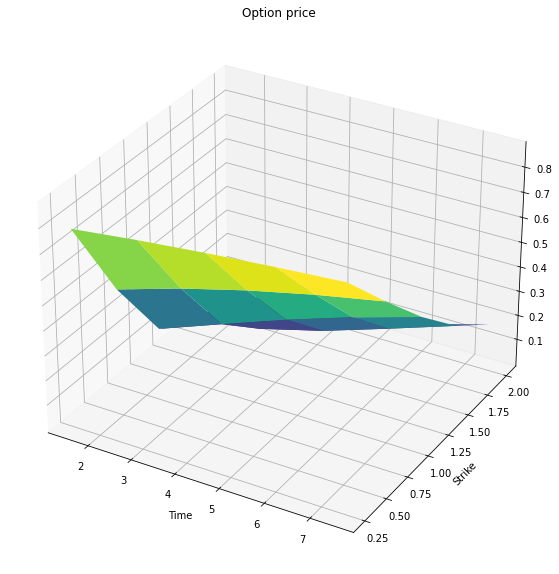

In [268]:
fig = plt.figure(figsize=(10, 10))
ax = plt.axes(projection='3d')
ax.plot_surface(X, Y, C0, rstride=1, cstride=1,
                cmap='viridis', edgecolor='none')
ax.set_title('Option price')
plt.xlabel("Time")
plt.ylabel("Strike")
None

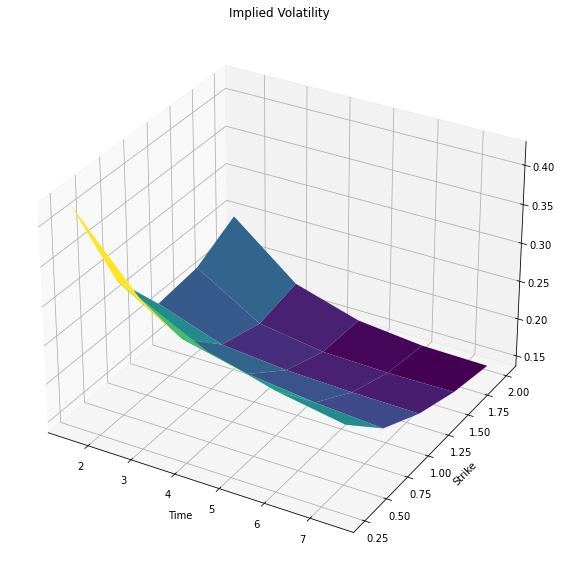

In [269]:
fig = plt.figure(figsize=(10, 10))
ax = plt.axes(projection='3d')
ax.plot_surface(X, Y, vol0, rstride=1, cstride=1,
                cmap='viridis', edgecolor='none')
ax.set_title('Implied Volatility')
plt.xlabel("Time")
plt.ylabel("Strike")
None

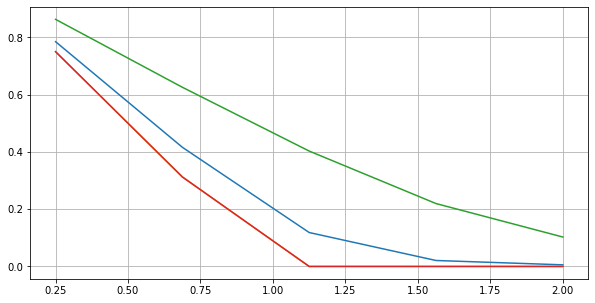

In [270]:
plt.figure(figsize=(10, 5))
payoff = np.maximum(0.0, S0 - Kn)
plt.plot()
for t in range(0, Nt, 3):
    plt.plot(Kn, C0[:, t])
    plt.plot(Kn, payoff)
plt.grid()

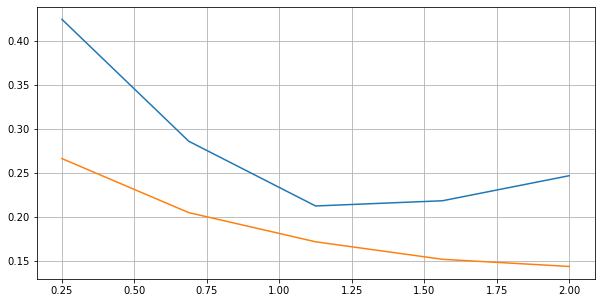

In [271]:
plt.figure(figsize=(10, 5))
for t in range(0, Nt, 3):
    plt.plot(Kn, vol0[:, t])
plt.grid()

In [272]:
t = 1

In [273]:
c, ders = getOptionPriceABDer(S0, Kn, Nu, Tn[t], r, v0, theta, rho, k, sig)

In [357]:
def getResudalAndGrad(C0, S, Kn, Nu, Tn, r, *heston_params):
    Nt = len(Tn)
    Nk = len(Kn)
    res  = np.zeros((0, ))
    J = np.zeros((5, 0))
    for t in range(Nt):
        c, ders = getOptionPriceABDer(S0, Kn, Nu, Tn[t], r, *heston_params)
        ders = np.asarray(ders)
        _res = c.reshape(-1) - C0[:, t].reshape(-1)
        res = np.r_[res, _res]
        J = np.c_[J, ders]
    f = np.sum(res ** 2)
    df = 2 * J @ res
    d2f = J @ J.T
    return res, J

In [422]:
a = np.ones((5, 5))

array([[1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 1.]])

In [467]:
def LMAlgorithm(Niter, C0, S0, Kn, Nu, Tn, r, v0, theta, rho, k, sig):
    heston_params = np.asarray( [v0, theta, rho, k, sig] )
    
    res, J = getResudalAndGrad(C0, S0, Kn, Nu, Tn, r, *heston_params)
    
    F = np.linalg.norm(res)
    
    w = 5
    mu = w * np.max(np.diag(J))
    
    nu = 2.0
    
    fs = []
    
    for i in range(Niter):
        I = np.diag(np.diag(J @ J.T))
        dtheta = np.linalg.solve( mu * I + J @ J.T, J @ res )
        heston_params_new = heston_params - dtheta
        
        res_new, J_new = getResudalAndGrad(C0, S0, Kn, Nu, Tn, r, *heston_params_new)
        
        F_new = np.linalg.norm(res_new)
        
        delta_L = np.dot( dtheta, mu * dtheta + J @ res )
        delta_F = F - F_new
        
        fs.append( F )
        
        if delta_L > 0 and delta_F > 0:
            J = J_new
            res = res_new
            F = F_new
            
            heston_params = heston_params_new
            
            mu /= 2.0
        else:
            mu *= nu
            nu *= 2
            i -= 1
            continue
            
        eps1, eps2, eps3 = 1e-10, 1e-10, 1e-30
        stop = F < eps1 or np.linalg.norm(dtheta) / np.linalg.norm(heston_params) < eps3
        if stop:
            break        
    return heston_params, fs

In [468]:
v0    = 0.175
theta = 0.02
rho   = 0.5
k     = 2.0
sig   = 0.5

In [469]:
Niter = 150

In [470]:
heston_params, fs = LMAlgorithm(Niter, C0, S0, Kn, Nu, Tn, r, v0, theta, rho, k, sig)

In [471]:
print(*heston_params.round(5), sep='\t')

0.175	0.015	-0.2	2.5	0.9


In [472]:
print(*[v0_0, theta_0, rho_0, k_0, sig_0], sep='\t')

0.175	0.015	-0.2	2.5	0.9


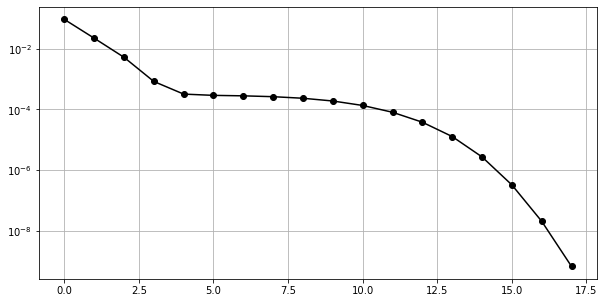

In [473]:
plt.figure(figsize=(10, 5))
plt.semilogy(fs, '-ok')
plt.grid()